In [ ]:
# 사용방법 - 복사하여 주석만 제거하여 사용
import sys
from pathlib import Path

# 현재 노트북(.ipynb)이 src/ 안에 있으니 상위 폴더(프로젝트 루트)를 추가
BASE_DIR    = Path().resolve().parent.parent    # Notebook이 src/ 안이라면 .parent
config_path = BASE_DIR / 'config' / 'data_paths.yaml'
sys.path.insert(0, str(BASE_DIR))


# 이제 바로 import
from scripts.data_loader import load_data

# 4번 가설 검증 : "성별에 따라 미세먼지의 질병(천식) 유발력이 다르게 나타난다."
p-value = 0.097 → 0.05보다 크므로 귀무가설을 기각할 수 없음

따라서 "성별에 따라 미세먼지의 질병 유발력이 다르다."는 증거는 통계적으로 부족합니다.

In [ ]:
# 천식·PM10 결합 결과 불러오기
asthma_df = load_data('pm10_asthma_processed_v1', section='processed')

# 날짜 매핑 → gender 붙이기
date_map =load_data('date_map', section='reference')
date_map['date_id'] = date_map['date_id'].astype(str)
date_map['year_month'] = date_map['date_id'].str[:4] + '-' + date_map['date_id'].str[4:6]
gender_map = date_map[['year_month']].drop_duplicates()

df = asthma_df.merge(gender_map, on='year_month', how='left')

# 월별 전국 총 진료 건수 집계
monthly = (
    df
    .groupby(['year_month','gender'], as_index=False)['visit_count']
    .sum()
    .rename(columns={'visit_count':'total_visit_count'})
)

pm10_wide = load_data('pm10_processed_v1', section='processed')
pm10_long = pm10_wide.melt(id_vars='year_month', var_name='region', value_name='pm10')
pm10_avg = pm10_long.groupby('year_month', as_index=False)['pm10'].mean()

In [7]:
df

,year_month,region,gender,age_group,visit_count
0,2006-01,가평,남자,1,74
1,2006-01,가평,남자,2,47
2,2006-01,가평,남자,3,11
3,2006-01,가평,남자,4,28
4,2006-01,가평,남자,5,55
...,...,...,...,...,...
370407,2023-12,화천,남자,6,12
370408,2023-12,화천,여자,1,5
370409,2023-12,화천,여자,4,9
370410,2023-12,화천,여자,5,12


In [8]:
# EDA용 최종 테이블
eda_df = monthly.merge(pm10_avg, on='year_month', how='left')
eda_df.head()

,year_month,gender,total_visit_count,pm10
0,2006-01,남자,286941,60.759375
1,2006-01,여자,312962,60.759375
2,2006-02,남자,146227,61.396875
3,2006-02,여자,157476,61.396875
4,2006-03,남자,178944,78.373437


In [ ]:
# 성별별 요약 통계 
gender_stats = eda_df.groupby('gender')[['total_visit_count']].agg(['mean','std'])
print(gender_stats)

       total_visit_count              
                    mean           std
gender                                
남자         133615.726852  46394.118749
여자         148601.314815  53773.687690


In [ ]:
# 성별별 상관계수
for s, sub in eda_df.groupby('gender'):
    r = sub['pm10'].corr(sub['total_visit_count'])
    print(f"{s} 상관계수: {r:.3f}")

남자 상관계수: 0.578
여자 상관계수: 0.619


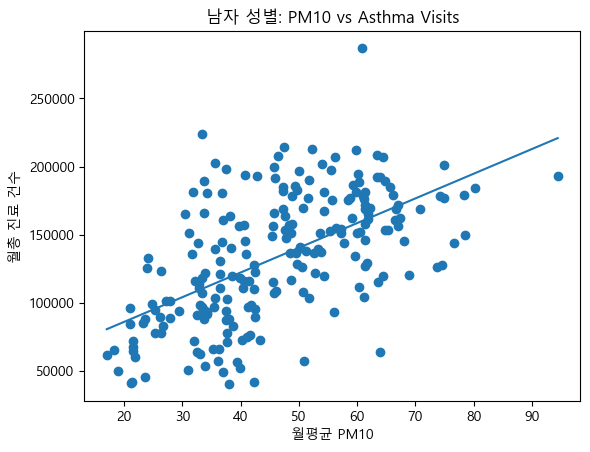

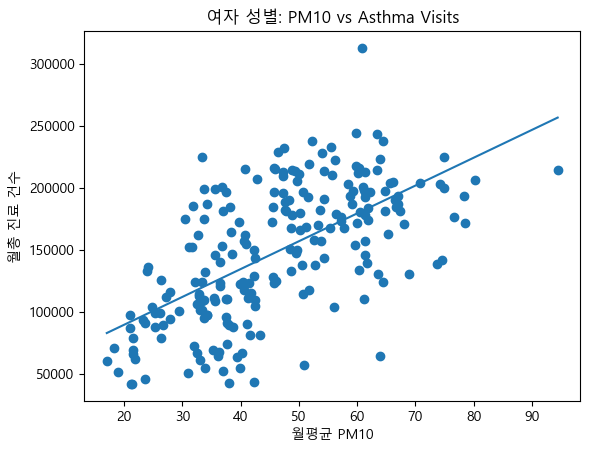

In [ ]:
# 성별별 산점도 + 회귀선 (matplotlib)
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

for s, sub in eda_df.groupby('gender'):
    x, y = sub['pm10'], sub['total_visit_count']
    coef = np.polyfit(x, y, 1)
    line = np.poly1d(coef)

    plt.figure()
    plt.scatter(x, y)
    xs = np.linspace(x.min(), x.max(), 100)
    plt.plot(xs, line(xs))
    plt.title(f"{s} 성별: PM10 vs Asthma Visits")
    plt.xlabel("월평균 PM10")
    plt.ylabel("월총 진료 건수")
    plt.show()

C:\Users\shinp\AppData\Local\Temp\ipykernel_49760\2239616917.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_visits, labels=labels)


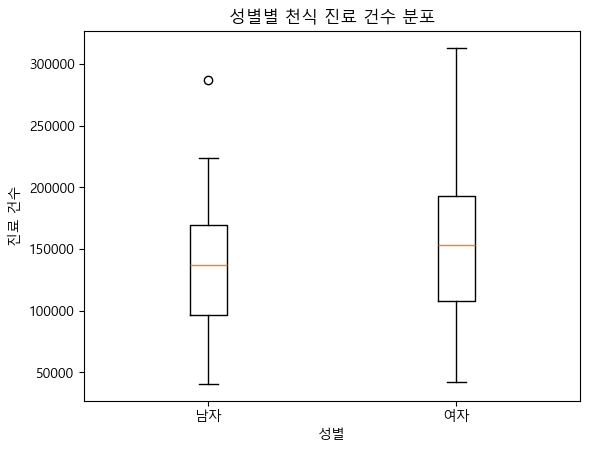

In [ ]:
# 박스플롯
# 진료 건수 분포
plt.figure()
data_visits = [sub['total_visit_count'].values for _, sub in eda_df.groupby('gender')]
labels = list(eda_df['gender'].unique())
plt.boxplot(data_visits, labels=labels)
plt.title("성별 천식 진료 건수 분포")
plt.xlabel("성별")
plt.ylabel("진료 건수")
plt.show()


In [20]:
# 상호작용 회귀(Interaction Regression)
import statsmodels.formula.api as smf

df['gender'] = df['gender'].astype('category')
model = smf.ols('total_visit_count ~ pm10 * gender', data=eda_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      total_visit_count   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.372
Method:                 Least Squares   F-statistic:                     86.00
Date:                Fri, 30 May 2025   Prob (F-statistic):           1.46e-43
Time:                        11:29:30   Log-Likelihood:                -5190.9
No. Observations:                 432   AIC:                         1.039e+04
Df Residuals:                     428   BIC:                         1.041e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          4.996e+04   8977.79

pm10:gender[T.여자]   coef=435.0883, p=0.097
p-value = 0.097 → 0.05보다 크므로 귀무가설을 기각할 수 없음

따라서 "성별에 따라 미세먼지의 질병 유발력이 다르다."는 증거는 통계적으로 부족합니다.

# 4번 가설 검증 : "성별에 따라 미세먼지의 질병(비염) 유발력이 다르게 나타난다."
p-value = 0.525 → 0.05보다 크므로 귀무가설을 기각할 수 없음

따라서 "성별에 따라 미세먼지의 질병(비염) 유발력이 다르다."는 증거는 통계적으로 부족합니다

In [ ]:
# 비염염·PM10 결합 결과 불러오기
rhinitis_df = load_data('pm10_rhinitis_processed_v1', section='processed')

# 날짜 매핑 → gender 붙이기
date_map =load_data('date_map', section='reference')
date_map['date_id'] = date_map['date_id'].astype(str)
date_map['year_month'] = date_map['date_id'].str[:4] + '-' + date_map['date_id'].str[4:6]
gender_map = date_map[['year_month']].drop_duplicates()

df2 = rhinitis_df.merge(gender_map, on='year_month', how='left')

# 월별 전국 총 진료 건수 집계
monthly = (
    df2
    .groupby(['year_month','gender'], as_index=False)['visit_count']
    .sum()
    .rename(columns={'visit_count':'total_visit_count'})
)

pm10_wide = load_data('pm10_processed_v1', section='processed')
pm10_long = pm10_wide.melt(id_vars='year_month', var_name='region', value_name='pm10')
pm10_avg = pm10_long.groupby('year_month', as_index=False)['pm10'].mean()

In [28]:
# EDA용 최종 테이블
eda_df2 = monthly.merge(pm10_avg, on='year_month', how='left')
eda_df2.head()

,year_month,gender,total_visit_count,pm10
0,2006-01,남자,888597,60.759375
1,2006-01,여자,1091168,60.759375
2,2006-02,남자,494345,61.396875
3,2006-02,여자,612448,61.396875
4,2006-03,남자,599841,78.373437


In [29]:
# 성별별 요약 통계 
gender_stats = eda_df2.groupby('gender')[['total_visit_count']].agg(['mean','std'])
print(gender_stats)

       total_visit_count               
                    mean            std
gender                                 
남자          8.207153e+05  264882.690747
여자          1.004684e+06  325165.258870


In [30]:
# 성별별 상관계수
for s, sub in eda_df2.groupby('gender'):
    r = sub['pm10'].corr(sub['total_visit_count'])
    print(f"{s} 상관계수: {r:.3f}")

남자 상관계수: 0.058
여자 상관계수: 0.103


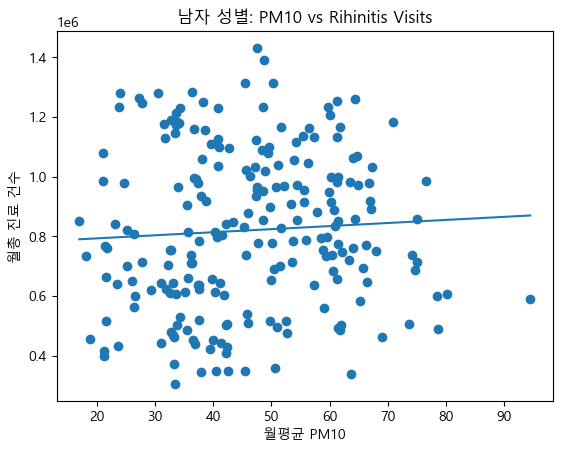

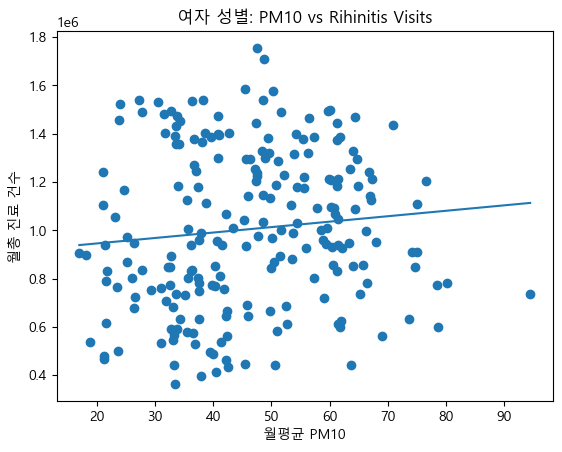

In [31]:
# 성별별 산점도 + 회귀선 (matplotlib)
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

for s, sub in eda_df2.groupby('gender'):
    x, y = sub['pm10'], sub['total_visit_count']
    coef = np.polyfit(x, y, 1)
    line = np.poly1d(coef)

    plt.figure()
    plt.scatter(x, y)
    xs = np.linspace(x.min(), x.max(), 100)
    plt.plot(xs, line(xs))
    plt.title(f"{s} 성별: PM10 vs Rihinitis Visits")
    plt.xlabel("월평균 PM10")
    plt.ylabel("월총 진료 건수")
    plt.show()

C:\Users\shinp\AppData\Local\Temp\ipykernel_49760\4011072647.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_visits, labels=labels)


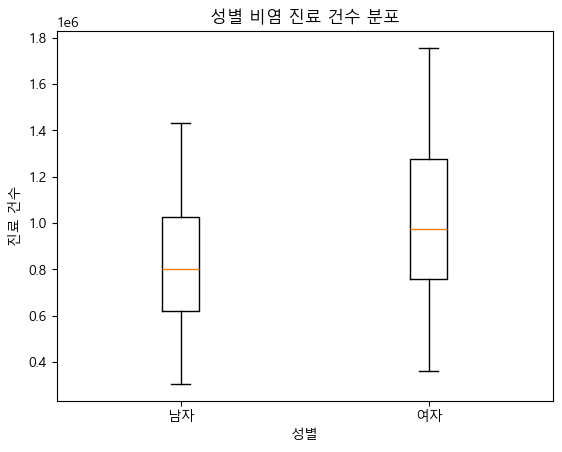

In [38]:
# 박스플롯
# 진료 건수 분포
plt.figure()
data_visits = [sub['total_visit_count'].values for _, sub in eda_df2.groupby('gender')]
labels = list(eda_df2['gender'].unique())
plt.boxplot(data_visits, labels=labels)
plt.title("성별 비염 진료 건수 분포")
plt.xlabel("성별")
plt.ylabel("진료 건수")
plt.show()

In [36]:
# 상호작용 회귀(Interaction Regression)
import statsmodels.formula.api as smf

df2['gender'] = df2['gender'].astype('category')
model = smf.ols('total_visit_count ~ pm10 * gender', data=eda_df2).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      total_visit_count   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     15.00
Date:                Fri, 30 May 2025   Prob (F-statistic):           2.66e-09
Time:                        11:55:04   Log-Likelihood:                -6053.5
No. Observations:                 432   AIC:                         1.212e+04
Df Residuals:                     428   BIC:                         1.213e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          7.731e+05   6.61e+0

pm10:gender[T.여자]   coef=1226.1065, p=0.525
p-value = 0.525 → 0.05보다 크므로 귀무가설을 기각할 수 없음

따라서 "성별에 따라 미세먼지의 질병(비염) 유발력이 다르다."는 증거는 통계적으로 부족합니다.